# Lego Analysis

Author: M. Tosic

Date: 01.2022

This notebook is part of my capstone project for a data science course. The project is independent and has no connection to the company LEGO.

A requirement for the project is also to show the implementation of the CRISP-DM process:

1. Business Understanding
2. Data Understanding
3. Prepare Data
4. Data Modeling(Optional)
5. Analysis & Evaluation of Results

# 1. Business Understanding

### Questions of interest

1. **What number of sets and themes was launched every year since 1991?**
2. **What themes where available over the years and with how many sets?**
3. **What where the yearly top ten most dominant themes by number of sets?**
4. **What were the record-breaking sets by piece count?**
5. **Do sets have more and more pieces in general?**
6. **What words do most often come up in set names?**
7. **Are lego sets becomming more and more expensive?**
8. **How does the value of lego sets change after they are not produced anymore (eol)?**
9. **What themes do best after eol?**

*eol = lego-term for end-of-life meaning the date when the set is not being produced)

# 2. Data Understanding

Data being used in this notebook has been downloaded from the following sources:

* https://brickset.com/
* https://rebrickable.com/downloads/

Contraints:
* No time series data on the price averages available. Assumption: price changes average out over time after eol. The price curves are already in a steady state.
* For the sake of simplicity and since the amount of time for this project was very limited I neglected inflation in the price calculations.
* No data available on unique minifigs in sets (minifig are popular for collectors that focus on them and are generally believed to drive up the prices of some sets after eol).

### 2.1 Import Libraries

In [1106]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100) #pd.set_option('display.max_rows', None)

#visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# import necessary libraries for batch import csv:
import os
import glob

#for counting elements in a list:
from collections import Counter

#needed for text processing:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

#datetime:
from datetime import datetime

### 2.2 Import Data

#### Functions Definition

In [881]:
def import_csv_with_date_column(filename, date_col_name, skiprows_val = 0):
    """Imports a csv file to a pandas dataframe while parsing a given column as datetime.
    INPUT
    filename: relative path to file
    date_col_name: name of the column containing dates as string
    skiprows_val: number of rows to skip depending on the number of rows in the csv file dedicated to header
    OUTPUT
    df: pandas dataframe
    """
    dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
    df = pd.read_csv(filename, parse_dates=[date_col_name], date_parser=dateparse,skiprows = skiprows_val)
    df.rename(columns=lambda x: x.strip(), inplace = True)
    print(df.dtypes)
    return df

def slice_2_date_range(df, date_col,start_date, end_date):
    """Slices up a dataframe by a given date-timeframe. Only the part in between the start and end date is kept.
    INPUT
    df: dataframe to slice
    date_col: name of the column containing datetime information as string
    start_date: start date as string
    end_date: end date as string
    """
    #greater than start date and smaller than the end date
    mask = (df[date_col] > start_date) & (df[date_col] <= end_date)
    df = df[mask].reset_index(drop = True)
    return df

def import_multiple_csv_files_2_df (relative_path):
    """ Function uses os and glob packages to import multiple csv files into one dataframe. 
    The current working directory should be the one where this notebook is located.
    INPUT: 
    Relative path to the files e.g. "./data/Kurac*.csv"
    OUTPUT: 
    One dataframe containting all csv files concatenated together over axis = 0.
    """
    path = os.getcwd()
    files = glob.glob(os.path.join(path, relative_path))
    
    print('Glob search with parameters:', relative_path)
   # print('Ingested files:')
    li = []
    for file in files:
        df_temp = pd.read_csv(file, index_col = None, header = 0)
        li.append(df_temp)
        #print(file)
    try:    
        df = pd.concat(li, axis=0, ignore_index=True)
        print('Done.')

    except:
        print('Something went wrong the concatenation of the files, returning None. Is the relative_path correctly set?')
        return(None)
    
    return (df)

#### Importing main data set

In [882]:
df = import_multiple_csv_files_2_df("./data/Brickset*.csv")

Glob search with parameters: ./data/Brickset*.csv
Done.


#### Importing exchange rate data that will be used to fill-in price-column:

It will later be evident that some pricing information is missing and the intention is to use available pricing date in other currencies to fill-in missing data.

In [883]:
#pounds to usd:
df_gdp_usd = import_csv_with_date_column("data/exchange-rate-historical-chart_pound-dollar.csv",  "date", 15)
df_gdp_usd = slice_2_date_range(df_gdp_usd, "date", "1991-01-01", "2021-12-31")
display(df_gdp_usd.head(3))

#eur to usd:
df_eur_usd = import_csv_with_date_column("data/exchange-rate-historical-chart_euro-dollar.csv",  "date", 15)
df_eur_usd = slice_2_date_range(df_eur_usd, "date", "1991-01-01", "2021-12-31")

display(df_eur_usd.head(3))

date     datetime64[ns]
value           float64
dtype: object


date  value
0 1991-01-02   1.94
1 1991-01-03   1.95
2 1991-01-04   1.93

date     datetime64[ns]
value           float64
dtype: object


date  value
0 1999-01-04   1.18
1 1999-01-05   1.18
2 1999-01-06   1.16

In [884]:
rate_eur_usd = df_eur_usd.value.mean()
rate_gbp_usd = df_gdp_usd.value.mean()
rate_eur_usd, rate_gbp_usd

(1.1970355369182681, 1.5725745846764236)

**Droping unnessecary columns**

In [885]:
df.drop(['Qty owned','UPC','Qty owned new', 
         'Qty owned used', 'EAN','Priority','Wanted', 'Height', 'Depth', 'Weight', 'Width', 
         'Notes','Qty wanted','RRP (CAD)','Flag 1 not used', 'Flag 2 not used', 'Flag 3 not used',
         'Flag 4 not used', 'Flag 5 not used', 'Flag 6 not used','Flag 7 not used', 'Flag 8 not used'], axis=1, inplace=True)

**Renaming columns to be able to use dot-notation and make them more intuitive (e.g. price instead of rrp)**

The "eol" in "eol-date" means in lego-lingo "end-of-life",eqivalent to date from which the set is retired from production and official sales through lego.

In [887]:
df.rename(columns = lambda x : x.replace(' ', '_').replace('(','').replace(')','').lower().strip(), inplace = True)
df.rename(columns={'rrp_usd': 'price', 
                   'value_new_usd': 'value_new', 
                   'value_used_usd':'value_used',
                   'exit_date': 'eol_date'}, inplace = True) 
df.columns

Index(['number', 'theme', 'subtheme', 'year', 'set_name', 'minifigs', 'pieces',
       'rrp_gbp', 'price', 'rrp_eur', 'value_new', 'value_used', 'launch_date',
       'eol_date'],
      dtype='object')

**Sorting values by year and launch date**

In [888]:
df.sort_values(["year","launch_date"], inplace = True)

**Parse date columns to datetime**

In [889]:
df['launch_date'] = pd.to_datetime(df['launch_date'])
df['eol_date'] = pd.to_datetime(df['eol_date'])

In [890]:
display(df.head(3)), display(df.tail(3));

number  theme                subtheme  year  \
0   819-1  Basic         Supplementaries  1991   
1  1040-1  Dacta                     NaN  1991   
2  1474-1  Basic  Universal Building Set  1991   

                            set_name  minifigs  pieces  rrp_gbp  price  \
0                     Blue baseplate       NaN    1.00      NaN   5.50   
1                               Farm      4.00   89.00      NaN    NaN   
2  Basic Building Set with Gift Item      1.00   69.00      NaN    NaN   

   rrp_eur  value_new  value_used launch_date eol_date  
0      NaN       6.26         NaN         NaT      NaT  
1      NaN        NaN         NaN         NaT      NaT  
2      NaN      24.64         NaN         NaT      NaT

number  theme            subtheme  year  \
4104  ISBN9781452182261-1  Books           Chronicle  2022   
4105  ISBN9781728257907-1  Books  Dorling Kindersley  2022   
4106  ISBN9781797214139-1  Books  Dorling Kindersley  2022   

                              set_name  minifigs  pieces  rrp_gbp  price  \
4104         The Art of the Minifigure       NaN     NaN      NaN    NaN   
4105  Build and Stick: NINJAGO Dragons       NaN     NaN      NaN    NaN   
4106                   Build Every Day       NaN     NaN      NaN    NaN   

      rrp_eur  value_new  value_used launch_date eol_date  
4104      NaN        NaN         NaN         NaT      NaT  
4105      NaN        NaN         NaN         NaT      NaT  
4106      NaN        NaN         NaN         NaT      NaT

### 2.3 Exploring Content

**Checking basic info on dataframe and descriptive statistics:**

In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15634 entries, 0 to 4106
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   number       15634 non-null  object        
 1   theme        15634 non-null  object        
 2   subtheme     12655 non-null  object        
 3   year         15634 non-null  int64         
 4   set_name     15634 non-null  object        
 5   minifigs     7171 non-null   float64       
 6   pieces       12118 non-null  float64       
 7   rrp_gbp      8172 non-null   float64       
 8   price        10234 non-null  float64       
 9   rrp_eur      3900 non-null   float64       
 10  value_new    10541 non-null  float64       
 11  value_used   8751 non-null   float64       
 12  launch_date  6624 non-null   datetime64[ns]
 13  eol_date     6624 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(7), int64(1), object(4)
memory usage: 1.8+ MB


There are 4 columns containting strings, two with datetime and the rest contain numeric data. Multiple columns have missing data.

In [307]:
 df.describe()

year  minifigs    pieces  rrp_gbp     price  rrp_eur  value_new  \
count 15,634.00  7,171.00 12,118.00 8,172.00 10,234.00 3,900.00  10,541.00   
mean   2,010.44      2.67    233.25    26.55     29.97    38.66      79.04   
std        8.05      2.79    470.34    39.71     44.52    56.64     213.08   
min    1,991.00      1.00      0.00     0.00      0.00     0.01       0.00   
25%    2,004.00      1.00     24.00     5.99      6.99     9.99      11.05   
50%    2,012.00      2.00     75.00    14.99     15.00    19.99      28.98   
75%    2,017.00      3.00    251.00    29.99     34.99    44.95      74.89   
max    2,022.00     33.00 11,695.00   699.99    799.99   799.99   9,773.99   

       value_used  
count    8,751.00  
mean        41.11  
std         75.64  
min          0.25  
25%          6.57  
50%         16.23  
75%         43.35  
max      1,391.39

**Check if there are duplicated values:**

In [891]:
df[df.duplicated()]

Empty DataFrame
Columns: [number, theme, subtheme, year, set_name, minifigs, pieces, rrp_gbp, price, rrp_eur, value_new, value_used, launch_date, eol_date]
Index: []

No duplicate rows in dataset.

**Unique values per column:**

In [309]:
df.nunique().sort_values(ascending = True)

minifigs          31
year              32
theme            141
rrp_eur          143
eol_date         165
rrp_gbp          270
price            322
launch_date      404
subtheme         801
pieces          1332
value_used      4522
value_new       6178
set_name       13328
number         15634
dtype: int64

**Investigate missing values in data set:**

In [310]:
print("Percentages of missing values:\n{}".format(df.isnull().sum()/df.shape[0]*100))

Percentages of missing values:
number         0.00
theme          0.00
subtheme      19.05
year           0.00
set_name       0.00
minifigs      54.13
pieces        22.49
rrp_gbp       47.73
price         34.54
rrp_eur       75.05
value_new     32.58
value_used    44.03
launch_date   57.63
eol_date      57.63
dtype: float64


In [311]:
df_missing_val_per = pd.DataFrame(df.isnull().sum()/df.shape[0]*100, columns=['value'])
df_missing_val_per_sorted = df_missing_val_per.sort_values(by = "value", ascending = False)

px.bar(df_missing_val_per_sorted, 
       x = df_missing_val_per_sorted.index, 
       y = "value", 
       labels = {"value":"percentage of missing values"})

**Comments:**
* There are NaN values in most columns.
* Most values are missing in rrp_eur, but this is ok since the analysis will be done in usd (due to value_new and value_used also being in usd). The available rrp_eur values can be used to fill-in missing data in the usd column.
* More than half of the items don't have a launch and exit date.
* The missing values for minifigs could just be due to the items being lego sets without any minifigures or those are other lego product merchandice.

**Tasks:**
* A quarter of the items are missing piece counts. This must be investigated since it could indicate the item is not a lego set but some other kind of merchandise from the database. I will aim to categorize the items into sets and other merchandice. A possible way to does this is to use the pieces count >0 or minifigure >0.

* Most prices are available in usd, also the value new and used is available in usd. If possible I will calculate missing values in usd by the columns of other currencies then drop the other columns to reduce complexity for further processing (one currency is enough for the intended analysis).

* Also some launch and eol dates are missing, I'll take a look at that. Sets from 2022 have probably not yet been released, and they will be excluded from the analysis.

**Make box-plots of all columns with numerival values:**

In [896]:
def make_plots_of_num_cols(df):
    """Creates boxplots of all numerical columns for the purpose of data exploration. Plotly express box() is used.
    INPUT
    df: dataframe with at least some numeric columns
    OUTPUT:
    Multiple boxplots, one for each numerical column"""
    
    for col in df.columns:
        if df[col].dtype == np.int64 or df[col].dtype == np.float64:
            #print(col)
            fig = px.box(df, x = col, points="all")
            fig.update_yaxes(visible = False, showticklabels = False)
            fig.show()
        else:
            continue

In [897]:
make_plots_of_num_cols(df)

## 3. Prepare Data

### Removing rows where there is no numeric data

In [898]:
df.shape

(15634, 14)

In [899]:
cond = df[['minifigs','pieces',
       "rrp_gbp", "rrp_eur", "price", 
       "value_new", "value_used", 
       "launch_date", "eol_date"]].isnull().values.all(axis=1) #no numerical data in all of the named columns
df['numeric_data_nan'] = np.where(cond, True, False)
df[df["numeric_data_nan"] == True].head(3)

number  theme     subtheme  year                 set_name  \
142  BK15SPR1991-1  Books  Brick Kicks  1991  BRICK KICKS Spring 1991   
143  BK16SUM1991-1  Books  Brick Kicks  1991  BRICK KICKS Summer 1991   
144  BK17FAL1991-1  Books  Brick Kicks  1991    BRICK KICKS Fall 1991   

     minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
142       NaN     NaN      NaN    NaN      NaN        NaN         NaN   
143       NaN     NaN      NaN    NaN      NaN        NaN         NaN   
144       NaN     NaN      NaN    NaN      NaN        NaN         NaN   

    launch_date eol_date  numeric_data_nan  
142         NaT      NaT              True  
143         NaT      NaT              True  
144         NaT      NaT              True

In [900]:
df = df[df["numeric_data_nan"] == False] #leave only rows where not all numeric data is NaN
df.head(3)

number  theme                subtheme  year  \
0   819-1  Basic         Supplementaries  1991   
1  1040-1  Dacta                     NaN  1991   
2  1474-1  Basic  Universal Building Set  1991   

                            set_name  minifigs  pieces  rrp_gbp  price  \
0                     Blue baseplate       NaN    1.00      NaN   5.50   
1                               Farm      4.00   89.00      NaN    NaN   
2  Basic Building Set with Gift Item      1.00   69.00      NaN    NaN   

   rrp_eur  value_new  value_used launch_date eol_date  numeric_data_nan  
0      NaN       6.26         NaN         NaT      NaT             False  
1      NaN        NaN         NaN         NaT      NaT             False  
2      NaN      24.64         NaN         NaT      NaT             False

In [901]:
df.shape

(14473, 15)

### Categorization of items to sets and minifigures while removing items such as gear, books, etc.

*From Lego.com: "We use numbers as a quick and convenient way to instantly identify any LEGO set. Numbers on the first sets we made were three digits long, but as we made more and more sets, we started using longer numbers. Currently, set numbers are five to seven digits long and are featured prominently on the box and instructions for the set."*

Sourcepage: 
https://www.lego.com/en-my/service/help/bricks-and-sets/replacement-parts/identifying-lego-set-and-part-numbers-blte3ec07db3789cacb

This will help me further narrow down true lego sets in the main data set and filter our the other merchandise.

**Drop columns where item number is not a valid set number according to lego.com**

Since the number column contains strings with an integrated separator, it is a good idea to split around the separator and divide the data into two columns. Both new columns need to be pure numbers for this to be a valid lepo set id.

In [902]:
df[['number_main','number_sub']] = df['number'].str.split('-',expand=True)

In [904]:
#drop rows where the main or sub numbers are not numeric
df.drop(df.index[df["number_main"].apply(lambda x: not (x.isnumeric()))], axis=0, inplace=True)
df.drop(df.index[df["number_sub"].apply(lambda x: not (x.isnumeric()))], axis=0, inplace=True)

In [905]:
df.drop(['number_main','number_sub'], axis = "columns", inplace = True)

**Adding category column with value set for all items with > 0 number of pieces:**

Going further, if a set has pieces it will be regarded as a set in the analysis.

In [906]:
df['category'] = np.where(df['pieces'] > 0, "set", "uncategorized")
df[df.category == "uncategorized"].head(3)

number    theme           subtheme  year  \
662    8299-1  Technic                NaN  1997   
678    9708-1     Gear          Education  1997   
15096  3978-1     Gear  Key Chains/Castle  1998   

                              set_name  minifigs  pieces  rrp_gbp  price  \
662                         Search Sub      1.00    0.00      NaN  50.00   
678    Intelligent House Activity Pack       NaN     NaN      NaN  12.00   
15096          Magic Wizard Key Chain        NaN     NaN      NaN   3.00   

       rrp_eur  value_new  value_used launch_date eol_date  numeric_data_nan  \
662        NaN     108.62       61.46         NaT      NaT             False   
678        NaN        NaN         NaN         NaT      NaT             False   
15096      NaN        NaN         NaN         NaT      NaT             False   

            category  
662    uncategorized  
678    uncategorized  
15096  uncategorized

**Dealing with uncategorized items:**

In [908]:
uncat_themes = set(df[(df.category == "uncategorized")].theme)
print(uncat_themes)

{'Marvel Super Heroes', 'DC Comics Super Heroes', 'Friends', 'Vidiyo', 'BrickHeadz', 'Legends of Chima', 'Unikitty', 'Books', 'Technic', 'Ninjago', 'Power Miners', 'Star Wars', 'Promotional', 'Duplo', 'Education', 'Sports', 'The LEGO Movie 2', 'Creator Expert', 'Super Mario', 'Clikits', 'Make and Create', 'Disney', 'City', 'Gear', 'Collectable Minifigures', 'Seasonal', 'Miscellaneous'}


In [909]:
for theme in uncat_themes:
    cond_2 = (df.theme == theme) & (df.category == "uncategorized")
    print("Theme:", theme)
    print("Number of rows:", df[cond_2].shape[0])
    display(df[cond_2].head(3))

Theme: Marvel Super Heroes
Number of rows: 1


number                theme       subtheme  year  set_name  minifigs  \
4076  242210-1  Marvel Super Heroes  Magazine Gift  2022  Iron Man       NaN   

      pieces  rrp_gbp  price  rrp_eur  value_new  value_used launch_date  \
4076     NaN      NaN    NaN      NaN       5.04         NaN         NaT   

     eol_date  numeric_data_nan       category  
4076      NaT             False  uncategorized

Theme: DC Comics Super Heroes
Number of rows: 2


number                   theme            subtheme  year  \
7594  5004816-1  DC Comics Super Heroes  Product Collection  2015   
3631   212010-1  DC Comics Super Heroes       Magazine Gift  2020   

                        set_name  minifigs  pieces  rrp_gbp  price  rrp_eur  \
7594  Super Heroes DC Collection       NaN     NaN      NaN 149.98      NaN   
3631                      Batman      1.00     NaN      NaN    NaN      NaN   

      value_new  value_used launch_date eol_date  numeric_data_nan  \
7594        NaN         NaN         NaT      NaT             False   
3631       3.38        2.73         NaT      NaT             False   

           category  
7594  uncategorized  
3631  uncategorized

Theme: Friends
Number of rows: 2


number    theme            subtheme  year  \
4805  5005553-1  Friends  Product Collection  2018   
1585    66673-1  Friends  Product Collection  2021   

                        set_name  minifigs  pieces  rrp_gbp  price  rrp_eur  \
4805  LEGO Friends Easter Bundle       NaN     NaN    35.97    NaN    43.97   
1585             Animal Gift Set       NaN     NaN      NaN    NaN      NaN   

      value_new  value_used launch_date   eol_date  numeric_data_nan  \
4805        NaN         NaN         NaT        NaT             False   
1585        NaN         NaN  2021-01-11 2021-12-31             False   

           category  
4805  uncategorized  
1585  uncategorized

Theme: Vidiyo
Number of rows: 4


number   theme            subtheme  year  \
1475   43101-0  Vidiyo  Bandmates Series 1  2021   
1489  43101-14  Vidiyo  Bandmates Series 1  2021   
1496   43108-0  Vidiyo  Bandmates Series 2  2021   

                             set_name  minifigs  pieces  rrp_gbp  price  \
1475  Bandmates Series 1 {Random box}       NaN     NaN     3.99   4.99   
1489  Bandmates Series 1 - Sealed Box       NaN     NaN     3.99   4.99   
1496  Bandmates Series 2 {Random box}       NaN     NaN     3.99   4.99   

      rrp_eur  value_new  value_used launch_date   eol_date  numeric_data_nan  \
1475     4.99        NaN         NaN  2021-01-03 2022-12-31             False   
1489     4.99        NaN         NaN  2021-01-03 2022-12-31             False   
1496     4.99        NaN         NaN  2021-01-10 2022-12-31             False   

           category  
1475  uncategorized  
1489  uncategorized  
1496  uncategorized

Theme: BrickHeadz
Number of rows: 1


number       theme     subtheme  year              set_name  \
5669  6315025-1  BrickHeadz  Promotional  2019  Amsterdam BrickHeadz   

      minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
5669       NaN     NaN      NaN    NaN      NaN     433.60         NaN   

     launch_date eol_date  numeric_data_nan       category  
5669         NaT      NaT             False  uncategorized

Theme: Legends of Chima
Number of rows: 19


number             theme       subtheme  year           set_name  \
6617  391214-1  Legends of Chima  Magazine gift  2014      Speedorz Ramp   
6619  391404-1  Legends of Chima  Magazine gift  2014             Worriz   
6620  391405-1  Legends of Chima  Magazine gift  2014  Crocodile Hideout   

      minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
6617       NaN     NaN      NaN    NaN      NaN       2.37         NaN   
6619       NaN     NaN      NaN    NaN      NaN       6.22         NaN   
6620       NaN     NaN      NaN    NaN      NaN       1.63         NaN   

     launch_date eol_date  numeric_data_nan       category  
6617         NaT      NaT             False  uncategorized  
6619         NaT      NaT             False  uncategorized  
6620         NaT      NaT             False  uncategorized

Theme: Unikitty
Number of rows: 1


number     theme             subtheme  year  \
4385  41775-14  Unikitty  Blind Bags Series 1  2018   

                                          set_name  minifigs  pieces  rrp_gbp  \
4385  Unikitty! - Blind Bags Series 1 - Sealed Box       NaN     NaN      NaN   

      price  rrp_eur  value_new  value_used launch_date   eol_date  \
4385    NaN      NaN        NaN         NaN  2018-01-06 2018-12-31   

      numeric_data_nan       category  
4385             False  uncategorized

Theme: Books
Number of rows: 2


number  theme subtheme  year                        set_name  minifigs  \
5988  4006-1  Books     LEGO  2000         Brick Tricks: Cool Cars       NaN   
5989  4007-1  Books     LEGO  2000  Brick Tricks: Fantastic Fliers       NaN   

      pieces  rrp_gbp  price  rrp_eur  value_new  value_used launch_date  \
5988     NaN      NaN   8.00      NaN        NaN         NaN         NaT   
5989     NaN      NaN   8.00      NaN        NaN         NaN         NaT   

     eol_date  numeric_data_nan       category  
5988      NaT             False  uncategorized  
5989      NaT             False  uncategorized

Theme: Technic
Number of rows: 1


number    theme subtheme  year    set_name  minifigs  pieces  rrp_gbp  \
662  8299-1  Technic      NaN  1997  Search Sub      1.00    0.00      NaN   

     price  rrp_eur  value_new  value_used launch_date eol_date  \
662  50.00      NaN     108.62       61.46         NaT      NaT   

     numeric_data_nan       category  
662             False  uncategorized

Theme: Ninjago
Number of rows: 1


number    theme            subtheme  year  \
4804  5005552-1  Ninjago  Product Collection  2018   

                        set_name  minifigs  pieces  rrp_gbp  price  rrp_eur  \
4804  LEGO NINJAGO Easter Bundle       NaN     NaN    42.95    NaN    44.95   

      value_new  value_used launch_date eol_date  numeric_data_nan  \
4804        NaN         NaN         NaT      NaT             False   

           category  
4804  uncategorized

Theme: Power Miners
Number of rows: 3


number         theme     subtheme  year  \
2556  4559288-1  Power Miners  Promotional  2009   
2557  4559385-1  Power Miners  Promotional  2009   
2558  4559387-1  Power Miners  Promotional  2009   

                                set_name  minifigs  pieces  rrp_gbp  price  \
2556  {Power Miners Promotional Polybag}      1.00     NaN      NaN    NaN   
2557  {Power Miners Promotional Polybag}      1.00     NaN      NaN    NaN   
2558  {Power Miners Promotional Polybag}      1.00     NaN      NaN    NaN   

      rrp_eur  value_new  value_used launch_date eol_date  numeric_data_nan  \
2556      NaN      29.50         NaN         NaT      NaT             False   
2557      NaN      14.63         NaN         NaT      NaT             False   
2558      NaN       9.26         NaN         NaT      NaT             False   

           category  
2556  uncategorized  
2557  uncategorized  
2558  uncategorized

Theme: Star Wars
Number of rows: 1


number      theme            subtheme  year                   set_name  \
1586  66674-1  Star Wars  Product Collection  2021  Skywalker Adventures Pack   

      minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
1586       NaN     NaN      NaN    NaN      NaN      66.58         NaN   

     launch_date   eol_date  numeric_data_nan       category  
1586  2021-01-11 2021-12-31             False  uncategorized

Theme: Promotional
Number of rows: 18


number        theme           subtheme  year             set_name  \
14860  4212850-1  Promotional  LEGO brand stores  2004    Easter Egg Orange   
4841   6258620-1  Promotional      Miscellaneous  2018  Classic Wooden Duck   
4842   6258622-1  Promotional      Miscellaneous  2018   Classic Wooden Bus   

       minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
14860       NaN     NaN      NaN    NaN      NaN      49.00         NaN   
4841        NaN     NaN      NaN    NaN      NaN      47.70         NaN   
4842        NaN     NaN      NaN    NaN      NaN      52.51         NaN   

      launch_date eol_date  numeric_data_nan       category  
14860         NaT      NaT             False  uncategorized  
4841          NaT      NaT             False  uncategorized  
4842          NaT      NaT             False  uncategorized

Theme: Duplo
Number of rows: 21


number  theme subtheme  year          set_name  minifigs  pieces  \
5838   2751-1  Duplo      NaN  2000           Egg Fun       NaN     NaN   
11429  5484-1  Duplo      NaN  2006      {Zoo animal}       NaN     NaN   
11431  5485-2  Duplo      NaN  2006  Zoo - Zoo Keeper       NaN     NaN   

       rrp_gbp  price  rrp_eur  value_new  value_used launch_date   eol_date  \
5838       NaN   4.00      NaN        NaN         NaN         NaT        NaT   
11429      NaN    NaN      NaN        NaN         NaN  2006-01-01 2009-12-31   
11431      NaN    NaN      NaN        NaN         NaN  2006-01-01 2007-12-31   

       numeric_data_nan       category  
5838              False  uncategorized  
11429             False  uncategorized  
11431             False  uncategorized

Theme: Education
Number of rows: 9


number      theme subtheme  year        set_name  minifigs  pieces  \
9282    9412-1  Education    Duplo  2003    Duplo Bricks       NaN     NaN   
12048   9310-1  Education      NaN  2007   Dinosaurs Set       NaN     NaN   
12492  45080-1  Education      NaN  2013  Creative Cards       NaN     NaN   

       rrp_gbp  price  rrp_eur  value_new  value_used launch_date eol_date  \
9282     28.99    NaN      NaN        NaN         NaN         NaT      NaT   
12048      NaN    NaN      NaN        NaN       89.99         NaT      NaT   
12492      NaN    NaN      NaN       6.57         NaN         NaT      NaT   

       numeric_data_nan       category  
9282              False  uncategorized  
12048             False  uncategorized  
12492             False  uncategorized

Theme: Sports
Number of rows: 1


number   theme  subtheme  year         set_name  minifigs  pieces  \
5896  3406-2  Sports  Football  2000  French Team Bus       NaN     NaN   

      rrp_gbp  price  rrp_eur  value_new  value_used launch_date   eol_date  \
5896      NaN    NaN      NaN        NaN         NaN  2000-01-04 2002-06-30   

      numeric_data_nan       category  
5896             False  uncategorized

Theme: The LEGO Movie 2
Number of rows: 2


number             theme       subtheme  year          set_name  \
5435   471906-1  The LEGO Movie 2  Magazine Gift  2019  Rex with Jetpack   
5582  5005738-1  The LEGO Movie 2            NaN  2019      Sticker roll   

      minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
5435      1.00     NaN      NaN    NaN      NaN       3.19         NaN   
5582       NaN     NaN     3.99   3.99     3.99        NaN         NaN   

     launch_date eol_date  numeric_data_nan       category  
5435         NaT      NaT             False  uncategorized  
5582         NaT      NaT             False  uncategorized

Theme: Creator Expert
Number of rows: 1


number           theme subtheme  year  \
1229  10282-2  Creator Expert   Adidas  2021   

                                               set_name  minifigs  pieces  \
1229  Adidas Originals Superstar X Footshop 'Bluepri...       NaN     NaN   

      rrp_gbp  price  rrp_eur  value_new  value_used launch_date   eol_date  \
1229    79.99  79.99    89.99        NaN         NaN  2021-01-07 2023-12-31   

      numeric_data_nan       category  
1229             False  uncategorized

Theme: Super Mario
Number of rows: 54


number        theme                   subtheme  year  \
3468  71361-0  Super Mario  Character Pack - Series 1  2020   
3469  71361-1  Super Mario  Character Pack - Series 1  2020   
3470  71361-2  Super Mario  Character Pack - Series 1  2020   

                                    set_name  minifigs  pieces  rrp_gbp  \
3468  Character Pack - Series 1 {Random bag}       NaN     NaN      NaN   
3469                              Paragoomba      1.00     NaN      NaN   
3470                                   Fuzzy      1.00     NaN      NaN   

      price  rrp_eur  value_new  value_used launch_date   eol_date  \
3468   4.99      NaN        NaN         NaN  2020-01-08 2020-12-31   
3469   4.99      NaN      12.92        5.39  2020-01-08 2020-12-31   
3470   4.99      NaN       6.00        4.67  2020-01-08 2020-12-31   

      numeric_data_nan       category  
3468             False  uncategorized  
3469             False  uncategorized  
3470             False  uncategorized

Theme: Clikits
Number of rows: 1


number    theme  subtheme  year                 set_name  minifigs  \
14672  7575-1  Clikits  Seasonal  2004  Clikits Advent Calendar       NaN   

       pieces  rrp_gbp  price  rrp_eur  value_new  value_used launch_date  \
14672     NaN    11.99  15.00      NaN      18.75         NaN  2004-01-10   

        eol_date  numeric_data_nan       category  
14672 2006-12-31             False  uncategorized

Theme: Make and Create
Number of rows: 1


number            theme subtheme  year                 set_name  \
11514  7794-1  Make and Create      NaN  2006  {Set with two minifigs}   

       minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
11514       NaN     NaN    19.99    NaN      NaN        NaN         NaN   

      launch_date eol_date  numeric_data_nan       category  
11514         NaT      NaT             False  uncategorized

Theme: Disney
Number of rows: 4


number   theme       subtheme  year                       set_name  \
1834  302102-1  Disney  Magazine Gift  2021           Rapunzel & Hairbrush   
1835  302103-1  Disney  Magazine Gift  2021           Cinderella's Kitchen   
1837  302105-1  Disney  Magazine Gift  2021  Lumiere, Cogsworth and Sultan   

      minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
1834       NaN     NaN      NaN    NaN      NaN       3.66         NaN   
1835       NaN     NaN      NaN    NaN      NaN       3.39         NaN   
1837       NaN     NaN      NaN    NaN      NaN       3.90         NaN   

     launch_date eol_date  numeric_data_nan       category  
1834         NaT      NaT             False  uncategorized  
1835         NaT      NaT             False  uncategorized  
1837         NaT      NaT             False  uncategorized

Theme: City
Number of rows: 2


number theme            subtheme  year                 set_name  \
10130    66540-1  City   Volcano Explorers  2016  City Volcano Value Pack   
4806   5005554-1  City  Product Collection  2018  LEGO City Easter Bundle   

       minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
10130       NaN     NaN      NaN    NaN      NaN      88.23       55.18   
4806        NaN     NaN    37.97    NaN    44.97        NaN         NaN   

      launch_date   eol_date  numeric_data_nan       category  
10130  2016-01-09 2016-12-31             False  uncategorized  
4806          NaT        NaT             False  uncategorized

Theme: Gear
Number of rows: 1873


number theme           subtheme  year                         set_name  \
678    9708-1  Gear          Education  1997  Intelligent House Activity Pack   
15096  3978-1  Gear  Key Chains/Castle  1998          Magic Wizard Key Chain    
15154  5701-1  Gear     Video Games/PC  1998                        LEGO Loco   

       minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
678         NaN     NaN      NaN  12.00      NaN        NaN         NaN   
15096       NaN     NaN      NaN   3.00      NaN        NaN         NaN   
15154       NaN     NaN      NaN  10.00      NaN        NaN         NaN   

      launch_date eol_date  numeric_data_nan       category  
678           NaT      NaT             False  uncategorized  
15096         NaT      NaT             False  uncategorized  
15154         NaT      NaT             False  uncategorized

Theme: Collectable Minifigures
Number of rows: 68


number                    theme  subtheme  year  \
14162   8683-0  Collectable Minifigures  Series 1  2010   
14180  8683-18  Collectable Minifigures  Series 1  2010   
14181   8684-0  Collectable Minifigures  Series 2  2010   

                                       set_name  minifigs  pieces  rrp_gbp  \
14162  LEGO Minifigures - Series 1 {Random bag}       NaN     NaN     1.99   
14180  LEGO Minifigures - Series 1 - Sealed Box       NaN     NaN   119.40   
14181  LEGO Minifigures - Series 2 {Random bag}       NaN     NaN     1.99   

       price  rrp_eur  value_new  value_used launch_date   eol_date  \
14162   1.99      NaN        NaN         NaN  2010-01-05 2010-12-31   
14180    NaN      NaN        NaN         NaN  2010-01-05 2010-12-31   
14181   1.99      NaN        NaN         NaN  2010-01-09 2010-12-31   

       numeric_data_nan       category  
14162             False  uncategorized  
14180             False  uncategorized  
14181             False  uncategorized

Theme: Seasonal
Number of rows: 1


number     theme   subtheme  year                     set_name  \
6807  5004259-1  Seasonal  Christmas  2014  Holiday Ornament Collection   

      minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
6807       NaN     NaN      NaN  47.94      NaN        NaN         NaN   

     launch_date eol_date  numeric_data_nan       category  
6807         NaT      NaT             False  uncategorized

Theme: Miscellaneous
Number of rows: 5


number          theme                    subtheme  year  \
8769  4000024-1  Miscellaneous  LEGO Inside Tour Exclusive  2017   
4743  4000025-1  Miscellaneous  LEGO Inside Tour Exclusive  2018   
5559  4000034-1  Miscellaneous  LEGO Inside Tour Exclusive  2019   

                           set_name  minifigs  pieces  rrp_gbp  price  \
8769  LEGO House Tree of Creativity       NaN     NaN      NaN    NaN   
4743          LEGO Ferguson Tractor       NaN     NaN      NaN    NaN   
5559              LEGO System House       NaN     NaN      NaN    NaN   

      rrp_eur  value_new  value_used launch_date eol_date  numeric_data_nan  \
8769      NaN   1,960.86         NaN         NaT      NaT             False   
4743      NaN   2,300.00         NaN         NaT      NaT             False   
5559      NaN   3,432.84         NaN         NaT      NaT             False   

           category  
8769  uncategorized  
4743  uncategorized  
5559  uncategorized

There are different types of items still in the uncategorized group. Some are real sets, some are minifigures, and others are merchandise. Dropping product collections, bundle, promotionals, sealed boxes, magazine gifts, shoes such as Adidas Original Superstar, etc. Other items that can be sorted as sets or minifigures are categorized. Eventhough sets are the main focus of the analysis, I've decided to create the minifigure category in case I choose to do a deepdive in that topic later.

In [910]:
drop_col_list = ['Star Wars', 'DC Comics Super Heroes', 'City', 'The LEGO Movie 2', 
                     'Legends of Chima', 'Marvel Super Heroes',  'Books', 'Creator Expert', 
                       'Ninjago', 'Vidiyo', 'Disney', 'Miscellaneous', 'Gear', 'Duplo', 
                     'BrickHeadz', 'Promotional', 'Friends', 'Seasonal', 'Unikitty']
set_list = ["Clikits", 'Education','Make and Create', 'Sports']
minifig_list = ['Collectable Minifigures', 'Power Miners', 'Super Mario','Technic']
print("Rows that will be dropped:", drop_col_list)
print("To be categorized as sets:", set_list)
print("To be categorized as minifigs:", minifig_list)

Rows that will be dropped: ['Star Wars', 'DC Comics Super Heroes', 'City', 'The LEGO Movie 2', 'Legends of Chima', 'Marvel Super Heroes', 'Books', 'Creator Expert', 'Ninjago', 'Vidiyo', 'Disney', 'Miscellaneous', 'Gear', 'Duplo', 'BrickHeadz', 'Promotional', 'Friends', 'Seasonal', 'Unikitty']
To be categorized as sets: ['Clikits', 'Education', 'Make and Create', 'Sports']
To be categorized as minifigs: ['Collectable Minifigures', 'Power Miners', 'Super Mario', 'Technic']


In [325]:
for theme in set_list:
    df.loc[(df.theme == theme) & (df.category == "uncategorized"),'category'] ='set'
for theme in minifig_list:
    df.loc[(df.theme == theme) & (df.category == "uncategorized"),'category'] = "minifig"

In [326]:
df = df.drop(df[(df.category == "uncategorized") & (df.theme.isin(drop_col_list))].index)
df.category.unique() #this should now show all items as either sets or minifigures.

array(['set', 'minifig'], dtype=object)

**Recategorize "Collectable Minifigures" as minifigs**


Collectable Minifigures also contain some pieces and are sometimes regarded as sets. I will aviod this since there is a lot of them and they could skew statistics for what people normally regard as lego sets.

In [911]:
df.loc[(df.theme == "Collectable Minifigures"), "category"] = "minifig"

In [913]:
set(df[df.theme == "Collectable Minifigures"].category) #checking if Collectable Minifigures are now minifigs.

{'minifig'}

**Since 2022 is incomplete we sill save the rows from 2022 in a new dataframe in case we need it later and remove it from the main one.**

In [914]:
df_2022 = df[df.year == 2022]

In [916]:
df = df[df.year != 2022]
print(set(df.year)) #checking which years are included in the dataset, 2022 shouldn't be there.

{1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021}


**Creating dataframe containing only sets, since they will be the main focus of the analysis:**


In [917]:
df_sets = df[df.category == "set"].sort_values(by = "year")

### Further preparation steps for exploration analysis

**Filling in price data in usd from other currencies where possible**


In [918]:
rate_eur_usd, rate_gdp_usd

(1.1970355369182681, 1.5725745846764236)

In [919]:
print("No. of rows where the price could be filled exclusively with gbp-data:")
mask_gbp = (df_sets.price.isna()) & (df_sets.rrp_eur.isna()) & (df_sets.rrp_gbp.notnull())
df_sets[mask_gbp].shape

No. of rows where the price could be filled exclusively with gbp-data:


(241, 16)

In [920]:
print("No. of rows where the price could be filled exclusively with eur-data:")
mask_eur = (df_sets.price.isna()) & (df_sets.rrp_gbp.isna()) & (df_sets.rrp_eur.notnull())
df_sets[mask_eur].shape

No. of rows where the price could be filled exclusively with eur-data:


(5, 16)

In [921]:
print("No. of rows where the price is NaN:")
df_sets[df_sets['price'].isnull()].shape

No. of rows where the price is NaN:


(3276, 16)

Using lambda functions to fill in NaN from correspnding columns taking into account the conversion rate.

In [922]:
df_sets["price_eur_calc"] = df_sets["rrp_eur"].apply(lambda x: x*rate_eur_usd) 
df_sets["price_gbp_calc"] = df_sets["rrp_gbp"].apply(lambda x: x*rate_gdp_usd)
df_sets.head(3)

number          theme         subtheme  year  \
0    819-1          Basic  Supplementaries  1991   
91  5165-1  Service Packs              NaN  1991   
92  5166-1  Service Packs              NaN  1991   

                                  set_name  minifigs  pieces  rrp_gbp  price  \
0                           Blue baseplate       NaN    1.00      NaN   5.50   
91  Hinges, Couplings and Tilting Bearings       NaN   31.00      NaN   3.00   
92        Lamp Holders, Tool Holder Plates       NaN   18.00      NaN    NaN   

    rrp_eur  value_new  value_used launch_date eol_date  numeric_data_nan  \
0       NaN       6.26         NaN         NaT      NaT             False   
91      NaN      20.00         NaN         NaT      NaT             False   
92      NaN      12.79         NaN         NaT      NaT             False   

   category  price_eur_calc  price_gbp_calc  
0       set             NaN             NaN  
91      set             NaN             NaN  
92      set             NaN             NaN

In [337]:
print("No. of rows where the price is NaN after adding data from the gdp column:")
df_sets['price'].fillna(df_sets['price_gbp_calc'], inplace=True)
df_sets[df_sets['price'].isnull()].shape

(2999, 18)

In [923]:
print("No. of rows where the price is NaN after adding data from the eur column:")
df_sets['price'].fillna(df_sets['price_eur_calc'], inplace=True)
df_sets[df_sets['price'].isnull()].shape

No. of rows where the price is NaN after adding data from the eur column:


(3228, 18)

In [924]:
df_sets[df_sets['price'].isnull()].head(3)

number          theme  subtheme  year                          set_name  \
92   5166-1  Service Packs       NaN  1991  Lamp Holders, Tool Holder Plates   
93   5271-1  Service Packs       NaN  1991      Tyres and Hubs 49.6 mm White   
102  6352-1           Town  Vehicles  1991                 Cargomaster Crane   

     minifigs  pieces  rrp_gbp  price  rrp_eur  value_new  value_used  \
92        NaN   18.00      NaN    NaN      NaN      12.79         NaN   
93        NaN    4.00      NaN    NaN      NaN       5.90         NaN   
102      1.00  140.00      NaN    NaN      NaN     115.92       24.24   

    launch_date eol_date  numeric_data_nan category  price_eur_calc  \
92          NaT      NaT             False      set             NaN   
93          NaT      NaT             False      set             NaN   
102         NaT      NaT             False      set             NaN   

     price_gbp_calc  
92              NaN  
93              NaN  
102             NaN

Creating a dataset with price data excluding rows where there is data missing.

In [925]:
df_sets_price = df_sets[df_sets['price'].notnull()]
df_sets_price.columns

Index(['number', 'theme', 'subtheme', 'year', 'set_name', 'minifigs', 'pieces',
       'rrp_gbp', 'price', 'rrp_eur', 'value_new', 'value_used', 'launch_date',
       'eol_date', 'numeric_data_nan', 'category', 'price_eur_calc',
       'price_gbp_calc'],
      dtype='object')

In [926]:
df_sets_price = df_sets_price.drop(['rrp_eur','price_gbp_calc', 'rrp_gbp', 'price_eur_calc'], axis = "columns")
df_sets = df_sets.drop(['rrp_eur','price_gbp_calc', 'rrp_gbp', 'price_eur_calc'], axis = "columns")

In [927]:
df_sets_price = df_sets_price.sort_values("year").reset_index(drop = True)
df_sets = df_sets.sort_values("year").reset_index(drop = True)

Final dataset for price analysis:

In [930]:
df_sets_price.head(3)

number  theme         subtheme  year              set_name  minifigs  \
0   819-1  Basic  Supplementaries  1991        Blue baseplate       NaN   
1  6540-1   Town           Police  1991           Pier Police      4.00   
2  6541-1   Town            Boats  1991  Intercoastal Seaport      5.00   

   pieces  price  value_new  value_used launch_date eol_date  \
0    1.00   5.50       6.26         NaN         NaT      NaT   
1  352.00  44.00     424.79       66.18         NaT      NaT   
2  545.00  63.75     369.00      165.57         NaT      NaT   

   numeric_data_nan category  
0             False      set  
1             False      set  
2             False      set

Final dataset for set analysis:

In [931]:
df_sets.head(3)

number  theme                subtheme  year  \
0   819-1  Basic         Supplementaries  1991   
1  1040-1  Dacta                     NaN  1991   
2  1474-1  Basic  Universal Building Set  1991   

                            set_name  minifigs  pieces  price  value_new  \
0                     Blue baseplate       NaN    1.00   5.50       6.26   
1                               Farm      4.00   89.00    NaN        NaN   
2  Basic Building Set with Gift Item      1.00   69.00    NaN      24.64   

   value_used launch_date eol_date  numeric_data_nan category  
0         NaN         NaT      NaT             False      set  
1         NaN         NaT      NaT             False      set  
2         NaN         NaT      NaT             False      set

**Prepare dataframe for value after eol analysis**


In [932]:
df_sets_price.eol_date.min(), df_sets_price.eol_date.max()

(Timestamp('1996-12-31 00:00:00'), Timestamp('2026-12-31 00:00:00'))

In [933]:
df_sets_price[df_sets_price.eol_date.notnull()].head(5)

number          theme    subtheme  year            set_name  minifigs  \
364  6712-1        Western     Cowboys  1996  Sheriff's Showdown      2.00   
365  6716-1        Western     Cowboys  1996       Covered Wagon      1.00   
366  6769-1        Western     Cowboys  1996       Fort Legoredo     10.00   
372  6518-1           Town  Coastguard  1996          Baja Buggy      1.00   
373  6493-1  Time Cruisers         NaN  1996  Flying Time Vessel      2.00   

     pieces  price  value_new  value_used launch_date   eol_date  \
364   28.00   4.00      81.10       15.67  1996-01-09 1998-12-31   
365   64.00   8.00     152.52       39.78  1996-01-09 1998-12-31   
366  687.00  85.00     400.00      223.58  1996-01-10 1998-12-31   
372   37.00   3.50      15.14        5.53  1996-01-07 1997-12-31   
373  237.00  44.00     112.47       40.77  1996-01-07 1998-12-31   

     numeric_data_nan category  
364             False      set  
365             False      set  
366             False      set  
372             False      set  
373             False      set

**Comments**
* end-of-life dates before 1996-12-31 are not available.
* Unfortunately, I couldn't find time series information about the value of sets after eol. The values provided are a snapshot from Jan 2022. The value of sets should go in to saturation at some point after eol. I will assume for the sake of simplicity that this saturation point has been reached. To be fair to sets who have just recently retired I will shorten the timeframe to sets with an end-of-life date on 31.12.2020.

In [934]:
df_eol = slice_2_date_range(df_sets_price,"eol_date","1996-12-31","2020-12-31")
display(df_eol.head(5)), df_eol.shape

number          theme    subtheme  year            set_name  minifigs  \
0  6712-1        Western     Cowboys  1996  Sheriff's Showdown      2.00   
1  6716-1        Western     Cowboys  1996       Covered Wagon      1.00   
2  6769-1        Western     Cowboys  1996       Fort Legoredo     10.00   
3  6518-1           Town  Coastguard  1996          Baja Buggy      1.00   
4  6493-1  Time Cruisers         NaN  1996  Flying Time Vessel      2.00   

   pieces  price  value_new  value_used launch_date   eol_date  \
0   28.00   4.00      81.10       15.67  1996-01-09 1998-12-31   
1   64.00   8.00     152.52       39.78  1996-01-09 1998-12-31   
2  687.00  85.00     400.00      223.58  1996-01-10 1998-12-31   
3   37.00   3.50      15.14        5.53  1996-01-07 1997-12-31   
4  237.00  44.00     112.47       40.77  1996-01-07 1998-12-31   

   numeric_data_nan category  
0             False      set  
1             False      set  
2             False      set  
3             False      set  
4             False      set

(None, (4407, 14))

In [935]:
df_eol = df_eol[df_eol["value_new"].notnull()] #remove rows where value_new is missing
df_eol.shape

(4340, 14)

The goal now is to create a column describing the change of value between the retail price and the current price as "new set". "New" is taken to mean a sealed set in mint condition.

In [940]:
def change_per(a,b):
    """Function to get a change of value in percent from numbers a and b, b being the later instance.
    INPUT:
    a: first instance
    b: second instance
    OUTPUT:
    result of calculation as float in percent
    """
    try:
        result = 100*(b - a)/a 
    except(ZeroDivisionError): 
        print("Division with zero.")
        print(a,b)
        result = None
    return result

First try showed the error division with zero. Checking how many items have the price zero:

In [941]:
df_eol[df_eol.price.values == 0].shape

(0, 15)

Removing rows where price is zero (those are predominantly promotional sets gifted for instance at an openning of a Lego store).

In [942]:
df_eol = df_eol[df_eol.price.values != 0]

In [943]:
df_eol["value_change_per"]  = df_eol.apply(lambda f: change_per(f['price'],f['value_new']), axis=1)
df_eol.head(5)

number          theme    subtheme  year            set_name  minifigs  \
0  6712-1        Western     Cowboys  1996  Sheriff's Showdown      2.00   
1  6716-1        Western     Cowboys  1996       Covered Wagon      1.00   
2  6769-1        Western     Cowboys  1996       Fort Legoredo     10.00   
3  6518-1           Town  Coastguard  1996          Baja Buggy      1.00   
4  6493-1  Time Cruisers         NaN  1996  Flying Time Vessel      2.00   

   pieces  price  value_new  value_used launch_date   eol_date  \
0   28.00   4.00      81.10       15.67  1996-01-09 1998-12-31   
1   64.00   8.00     152.52       39.78  1996-01-09 1998-12-31   
2  687.00  85.00     400.00      223.58  1996-01-10 1998-12-31   
3   37.00   3.50      15.14        5.53  1996-01-07 1997-12-31   
4  237.00  44.00     112.47       40.77  1996-01-07 1998-12-31   

   numeric_data_nan category  value_change_per  
0             False      set          1,927.50  
1             False      set          1,806.50  
2             False      set            370.59  
3             False      set            332.57  
4             False      set            155.61

## 4. Analysis and Evaluation

### Function Definition

In [365]:
def make_h_bar_chart(df, x, y, color, text, title, labels = {}):
    """ Function uses plotly express to plot a horizontal bar chart. 
    The given text column is displayed insid of the bars.
    INPUT:
    df: dataframe
    x: column name as string
    y: must be index column as df.index
    text: text column to use for the bars
    title: plot title as str
    labels: empty dict by default, labels can be changed by entering e.g. {"index":"year"}
    
    OUTPUT: 
    plotly figure as fig-object
    """
    
    fig = px.bar(df, 
             x=x, y=y, 
             color = color, orientation='h', text = text,  
             title = title, labels = labels)
    fig.update_layout(yaxis = dict(tickmode = 'array',tickvals =y, ticktext = list(df.year)))
    fig.update_layout(xaxis = dict(tickmode = 'linear',tick0 = 0,dtick = 1000))
    fig.update_traces(textfont_size=12, textangle=0, textposition="inside")
    return fig

In [362]:
def create_record_breaker_dataset(df, col):
    #Record-winner in 1991
    df_winner_1991 = df_sets[df_sets.year == 1991].sort_values(col, ascending = False).head(1)
    
    mask = df_sets[col].values >= df_winner_1991[col].values[0]
    df_winners = df_sets[mask].sort_values(by = ["year", "launch_date"])
    
    df_winners["cummulative"] = df_winners[col].cummax()
    df_winners.drop_duplicates(subset = "cummulative", inplace = True)
    df_winners.reset_index(drop = True, inplace = True)
    
    return df_winners

### 1. What number of sets and themes was launched every year since 1991?

To get the number of sets or themes per year the goupby method is implemented.

In [946]:
df_set_count = df_sets.groupby(by = ["year", "theme"]).count().sort_values(by = ["year","number"], ascending = (True, False)).reset_index()
df_set_count.head(10)

year          theme  number  subtheme  set_name  minifigs  pieces  price  \
0  1991          Duplo      36         0        36        25      36      7   
1  1991  Service Packs      22         8        22         0      22     14   
2  1991           Town      22        22        22        19      22     11   
3  1991          Space      13        13        13        11      13      4   
4  1991         Trains      12        12        12         7      12     11   
5  1991          Basic      11         5        11         5      11      2   
6  1991          Dacta       7         2         7         3       7      0   
7  1991        Technic       6         1         6         0       6      2   
8  1991        Pirates       5         2         5         5       5      4   
9  1991          Boats       3         0         3         3       3      3   

   value_new  value_used  launch_date  eol_date  numeric_data_nan  category  
0          9          15            0         0                36        36  
1         21           6            0         0                22        22  
2         22          22            0         0                22        22  
3         11          13            0         0                13        13  
4         12          12            0         0                12        12  
5          5           6            0         0                11        11  
6          1           2            0         0                 7         7  
7          6           6            0         0                 6         6  
8          5           5            0         0                 5         5  
9          3           3            0         0                 3         3

In [984]:
print("No. of different themes per year:")
df_themes_count = df_sets.groupby(by = ["year"]).nunique().reset_index()
df_themes_count.head(3)

No. of different themes per year:


year  number  theme  subtheme  set_name  minifigs  pieces  price  \
0  1991     142     15        26       141        11      91     42   
1  1992     107     11        28       103         8      76     40   
2  1993     151     13        31       148        10     104     49   

   value_new  value_used  launch_date  eol_date  numeric_data_nan  category  
0         95          93            0         0                 1         1  
1         76          79            0         0                 1         1  
2        115         101            0         0                 1         1

In [1001]:
fig1 = px.area(df_set_count, "year", "number",  
       color = "theme", title = "Number of sets launched every year",
      labels = {"number":"set count"})
fig1.update_layout(xaxis = dict(tickmode = 'linear',tick0 = 0,dtick = 2))
fig1.show()

In [1025]:
def trendline_scatter_plot(df,x,y,title,labels = {}, scatter_color = "blue"):
    """Returns a plotly express figure containing scatter plot including a trendline.
    INPUT:
    df: dataframe
    x: columnname as string
    y: columnname as strin
    title: string for title
    labels: if needed labels can be renamed by writing the new values as dictionary. Default is {}.
    scatter_color: color for dots and trendline, default is blue
    OUTPUT
    Returns plotly figure
    """

    fig = px.scatter(df_themes_count, x=x, y=y, 
                 trendline="ols", 
                 title = title, 
                 labels = labels, color_discrete_sequence=[scatter_color])
    fig.update_layout(xaxis = dict(tickmode = 'linear',tick0 = 0,dtick = 2))
    return fig

In [1026]:
trendline_scatter_plot(df_themes_count, "year", "number",
                       "No. of sets per year with trendline",
                       {"number":"no. of sets"}, "red")

In [1027]:
trendline_scatter_plot(df_themes_count, "year", "theme",
                       "No. of themes per year with trendline",
                       {"theme":"no. of themes"})

**Comment**

The total number of sets as well as the number of themes seems to oscillate slightly from year to year. However both show a positive trend. While the number of themes has more than doubled since 1991, the total number of sets has grown with just under 6 times.

### 2. What themes where available over the years and with how many sets?

In [1014]:
df_temp = df_sets.groupby(by = ["year","theme"]).count().sort_values(by =["year", "number"], ascending = (True, False))
df_1 = pd.DataFrame(df_temp["number"])
df_1.reset_index(inplace = True);
df_1.head(3)

year          theme  number
0  1991          Duplo      36
1  1991  Service Packs      22
2  1991           Town      22

In [1016]:
fig = px.scatter(df_1, x = "year", y = "theme", color = "theme", size = "number",
              title = "Available themes in the period 1991-2021. The size of the circle indicates the number of sets.")
fig.update_layout(height=1750,
                  font=dict(size=9),
                  yaxis = dict(tickmode = 'linear',tick0 = 1,dtick = 1),
                  xaxis = dict(tickmode = 'linear',tick0 = 0,dtick = 1),
                  showlegend = False)
fig.update_traces(mode='markers+lines')#, textfont_size=3)

**Comment**

Duplo seems to be one of the most long lasting themes in lego. Other themes from the nineties continuing to this day are Creator & Star Wars.

### 3. What where the yearly top ten most dominant themes by number of sets?

In [1018]:
df_2 = df_1.groupby(by = ["year"]).head(10).reset_index()
df_2.head(12)

index  year          theme  number
0       0  1991          Duplo      36
1       1  1991  Service Packs      22
2       2  1991           Town      22
3       3  1991          Space      13
4       4  1991         Trains      12
5       5  1991          Basic      11
6       6  1991          Dacta       7
7       7  1991        Technic       6
8       8  1991        Pirates       5
9       9  1991          Boats       3
10     15  1992           Town      27
11     16  1992          Duplo      17

In [1019]:
fig = px.bar(df_2, x = "number",y= "year", color = "theme", 
             orientation='h', text = "theme", 
             title = "Yearly top 10 themes by number of sets")
fig.update_layout(height=1000,showlegend = False,
                  yaxis = dict(tickmode = 'linear',tick0 = 0,dtick =1, autorange = "reversed"),
                  xaxis = dict(tickmode = 'linear',tick0 = 0,dtick = 50))
fig.update_traces(textfont_size=12, textangle=0, textposition="inside")

**Comment**

Duplo, City, Creator, Ninjago and Friends have reached the top 10 in the past five years consecutively. The past three years however also show a steady increase in Marvel Super Heroes Sets.

### 4. What were the record-breaking sets by piece count?

In [1028]:
df_piece_count_winners = create_record_breaker_dataset(df_sets,"pieces")
df_piece_count_winners.head()

number           theme                   subtheme  year  \
0   9452-1           Dacta                        NaN  1991   
1   9287-1       Education                       Town  1996   
2   3450-1  Creator Expert                 Sculptures  2000   
3  10030-1       Star Wars  Ultimate Collector Series  2002   
4  10143-1       Star Wars  Ultimate Collector Series  2005   

                  set_name  minifigs   pieces  price  value_new  value_used  \
0     Giant LEGO topic set       NaN 2,165.00    NaN        NaN         NaN   
1    Bonus Lego Basic Town     11.00 2,456.00    NaN     511.29         NaN   
2        Statue of Liberty       NaN 2,882.00 199.00     200.00      793.69   
3  Imperial Star Destroyer       NaN 3,096.00 269.99   1,471.58      535.00   
4            Death Star II       NaN 3,441.00 269.99   2,449.00    1,206.66   

  launch_date   eol_date  numeric_data_nan category  cummulative  
0         NaT        NaT             False      set     2,165.00  
1         NaT        NaT             False      set     2,456.00  
2  2000-11-15 2002-12-31             False      set     2,882.00  
3  2002-06-12 2007-12-31             False      set     3,096.00  
4  2005-01-09 2007-12-31             False      set     3,441.00

In [1031]:
#Creating a column to be used as the text in the bar chart:
df_piece_count_winners["text"] = df_piece_count_winners["set_name"] +" "+ "(" + df_piece_count_winners["number"] +")"

In [1030]:
fig = make_h_bar_chart(df_piece_count_winners, "pieces",df_piece_count_winners.index, "theme",
                 "text", "Record breaking sets by piece count",{"index":"year"})
fig.show()

**Comment**

The World Map is the largest set of all time, in terms of piece count, followed by the Colosseum and Star Wars Millennium Falcon. 4 of the record-breaking sets since 1991 are from the Star Wars Theme and 3 from Creator Expert.

### 5. Do sets have more and more pieces in general?

In [367]:
df_sets_size = df_sets.groupby(by = "year").pieces.describe().reset_index()
df_sets_size.head(5)

year  count   mean    std  min   25%   50%    75%      max
0  1991 142.00 130.44 251.15 1.00 13.25 38.50 137.25 2,165.00
1  1992 107.00 122.14 165.31 1.00 23.50 48.00 164.00   954.00
2  1993 151.00 124.65 177.41 1.00 21.50 43.00 156.50   912.00
3  1994 143.00 126.29 218.77 2.00 19.00 45.00 139.00 1,343.00
4  1995 163.00 148.19 226.76 1.00 20.00 47.00 194.00 1,733.00

In [1036]:
#Show the median and mean of the number of pieces per year on one plot:
fig = px.line(title = "Median and mean of the number of pieces per year")
fig.add_scatter(name="mean", x=df_sets_size['year'], y=df_sets_size['mean'], mode='lines+markers')
fig.add_scatter(name="median",x=df_sets_size['year'], y=df_sets_size['50%'], mode='lines+markers')
fig.update_xaxes(title="year")
fig.update_layout(xaxis = dict(tickmode = 'linear',tick0 = 0,dtick = 1))
fig.show()

In [1040]:
fig = px.box(df_sets, "year", "pieces", title = "Boxplot of pieces per year")
fig.update_layout(xaxis = dict(tickmode = 'linear',tick0 = 0,dtick = 1))
fig.show()

Sets seem be getting larger and larger, as seen by the median, however since the mean is going up that means there is more and more variation in the number of pieces particularily towards the higher numbers. The boxplot also show more outliers in recent years.

### 6. What words do most often come up in set names?

To see what words most often appear a tokenizer and lemmatizer is implemented, striping the stricts to basi words and remove punctiation and stop words.

In [1070]:
def tokenizer_lemmatizer(text, n):
    """Function for text processing, in particular it replaces urls, tokenizes and lemmatizes the words in a given text. 
    Only tokens with longer than one character are returned.
    INPUT
    text: text to process as str
    n: a lower limit on the number of characters to allow in the token
    OUTPUT:
    tokens: list of tokenized words"""
    
    # normalize case, remove punctuation and numbers
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())#[^a-zA-Z]
    
    # tokenize text with tokenizer
    tokens = word_tokenize(text)
    
    # lemmatize, remove english stop words 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words("english")]
    
    multi_char_token =[x for x in tokens if len(x)>=n]

    return multi_char_token

In [1071]:
results_list = []
# applying the tokenizer_lemmatizer to the set name column and adding the words to a list
df_sets.set_name.apply(lambda x: results_list.extend(tokenizer_lemmatizer(x, 2))); 
print(results_list[:10])

['blue', 'baseplate', 'farm', 'basic', 'building', 'set', 'gift', 'item', 'airport', 'security']


In [1072]:
results_count = Counter(results_list) # apply a counter to the list, counting the appearance of unique words

#create a dataframe from the counter dictionary
df_results_count = pd.DataFrame.from_dict(results_count, orient='index', columns = ["col"]).reset_index()

#rename columns and then sort values
df_results_count.rename(columns = {'index':"word", "col":"occurances"}, inplace = True)
df_results_count.sort_values(by = "occurances", ascending = False, inplace = True)

#reset index
df_results_count.reset_index(drop = True, inplace = True)
df_results_count.head(10)

word  occurances
0    pack         570
1     set         492
2   brick         236
3   value         224
4   truck         208
5  bucket         186
6    lego         179
7    fire         176
8   bonus         175
9    city         156

In [1074]:
fig = px.bar(df_results_count.head(25), "word", "occurances",
       color = "word", text = "occurances",
       title = "Top 25 most frequent words in set names")
fig.update_traces(textfont_size=12, textangle=0, textposition="inside")
fig.show()                     
#fig.update_layout(xaxis = dict(visible = False, matches = None))

Pack, set and brick are probably not so surprising. Intresstingly truck is so high on the list. Most of the words are generric toy terms and not part of any license.

### 7. Are lego sets becomming more and more expensive?

In [1076]:
#Calculating average price per year.
df_expense = pd.DataFrame(df_sets_price.groupby(by = "year").mean()).reset_index()
df_expense.head()

year  minifigs  pieces  price  value_new  value_used  numeric_data_nan
0  1991      2.83  129.98  22.86     198.98       63.59              0.00
1  1992      3.03  155.44  23.37     191.67       56.31              0.00
2  1993      2.79  152.20  21.55     175.48       52.54              0.00
3  1994      2.69  167.21  28.49     179.69       59.67              0.00
4  1995      2.84  187.92  25.27     156.63       47.19              0.00

In [1078]:
#calculating price per piece:
df_expense["price_per_piece"] = df_expense.price.values / df_expense.pieces.values
df_expense.head()

year  minifigs  pieces  price  value_new  value_used  numeric_data_nan  \
0  1991      2.83  129.98  22.86     198.98       63.59              0.00   
1  1992      3.03  155.44  23.37     191.67       56.31              0.00   
2  1993      2.79  152.20  21.55     175.48       52.54              0.00   
3  1994      2.69  167.21  28.49     179.69       59.67              0.00   
4  1995      2.84  187.92  25.27     156.63       47.19              0.00   

   price_per_piece  
0             0.18  
1             0.15  
2             0.14  
3             0.17  
4             0.13

In [1083]:
fig = px.scatter(df_expense,"year", "price", size = "price_per_piece",
       color = "price_per_piece", 
       title = "Yearly mean price per set 1991-2021", trendline = "ols",
       labels = {"price":"average price in USD", "price_per_piece": "price per piece"})
fig.update_layout(xaxis = dict(tickmode = 'linear',tick0 = 1,dtick = 2))
fig.show()

The trend of sets getting more and more expensive is very clear. The average in 2021 is more than double the price in 1991. However price per piece has actually reduced.

### 8. How does the value of lego sets change after they are not produced anymore (eol)?

Descriptive statistics of value change in percent:

In [1085]:
df_eol.value_change_per.describe()

count    4,327.00
mean       182.27
std        301.29
min        -81.01
25%         30.74
50%         99.25
75%        232.46
max     10,413.86
Name: value_change_per, dtype: float64

* The median is at about just bellow 100%.
* A mean value change is at 181%, but this is influenced by the outliers more than the median (one outlier topping at 10412%).
* The worst value depriciation is at -81%.



In [1087]:
df_eol_top = df_eol.sort_values(by = "value_change_per")
df_eol_top["text"] = df_eol_top["set_name"] +" "+ "(" + df_eol_top["number"] +")"
df_eol_top_25 = df_eol_top.tail(25).reset_index(drop = True)
df_eol_top_25.head(10)

number        theme   subtheme  year  \
0  3438-1         Town    Special  1999   
1  5956-1  Adventurers     Jungle  1999   
2  5918-1  Adventurers     Desert  1998   
3  7884-1       Batman        NaN  2008   
4  8734-1     Bionicle   Warriors  2006   
5  8914-1     Bionicle  Toa Mahri  2007   
6  8531-1     Bionicle   Toa Mata  2001   
7  8601-1     Bionicle  Toa Metru  2004   
8  6716-1      Western    Cowboys  1996   
9  1269-1       Castle      Ninja  1999   

                                   set_name  minifigs  pieces  price  \
0                      McDonalds Restaurant      2.00   88.00  10.00   
1                        Expedition Balloon      4.00  175.00  20.00   
2                          Scorpion Tracker      1.00   35.00   4.00   
3  Batman's Buggy: The Escape of Mr. Freeze      2.00   76.00   9.99   
4                                   Brutaka       NaN  193.00  19.99   
5                                 Toa Hahli       NaN   59.00   9.99   
6                                    Pohatu       NaN   49.00   7.00   
7                                    Vakama       NaN   48.00   8.00   
8                             Covered Wagon      1.00   64.00   8.00   
9                               White Ninja      1.00   23.00   3.00   

   value_new  value_used launch_date   eol_date  numeric_data_nan category  \
0     161.47       79.17  1999-08-20 2000-04-30             False      set   
1     324.00      167.59  1999-01-01 1999-12-31             False      set   
2      65.00       15.79  1998-01-01 1999-12-31             False      set   
3     164.19       76.46  2008-01-06 2008-12-31             False      set   
4     331.75      109.13  2006-01-03 2007-07-31             False      set   
5     170.40       28.85  2007-01-08 2008-07-31             False      set   
6     126.64       13.18  2001-01-02 2002-06-30             False      set   
7     152.17       13.36  2004-01-03 2004-12-31             False      set   
8     152.52       39.78  1996-01-09 1998-12-31             False      set   
9      60.00       37.57  1999-11-15 2000-12-31             False      set   

   value_change_per                                               text  
0          1,514.70                      McDonalds Restaurant (3438-1)  
1          1,520.00                        Expedition Balloon (5956-1)  
2          1,525.00                          Scorpion Tracker (5918-1)  
3          1,543.54  Batman's Buggy: The Escape of Mr. Freeze (7884-1)  
4          1,559.58                                   Brutaka (8734-1)  
5          1,605.71                                 Toa Hahli (8914-1)  
6          1,709.14                                    Pohatu (8531-1)  
7          1,802.12                                    Vakama (8601-1)  
8          1,806.50                             Covered Wagon (6716-1)  
9          1,900.00                               White Ninja (1269-1)

In [1088]:
fig = make_h_bar_chart(df_eol_top_25, "value_change_per",df_eol_top_25.index, "theme",
                 "text", "Top 25 value increase sets after eol",
                       {"index":"sets with set number and year of launch","value_change_per":"value change in %"})
fig.update_layout(height=999)
fig.show()

The winner is the Spider Man Action pack. Interesstingly enough this lego set is actually a bundle and seems to be very rare. The following three sets are from the Bionicle line from 2001. Cafe Corner is another well known set being the first of the so-callec Creator Expert modular buildings. This started a series of yearly editions lasting until today making this first set a highly demanded item.

### 9. What themes do best after eol?

In [1090]:
df_eol.groupby(by = "theme").value_change_per.describe().sort_values(by = "50%", ascending = False).head(20)

count     mean      std      min      25%      50%  \
theme                                                                           
Avatar The Last Airbender   2.00 1,611.07   828.15 1,025.48 1,318.28 1,611.07   
Western                    12.00 1,069.21   509.85   370.59   711.63 1,032.99   
Batman                     13.00   796.85   330.14   347.20   610.73   706.50   
Vikings                     7.00   677.14   282.31   232.01   521.54   670.34   
Aqua Raiders                1.00   560.06      NaN   560.06   560.06   560.06   
Rock Raiders                6.00   574.86   203.51   276.54   518.46   546.62   
Spider-Man                  8.00   518.40   177.97   240.14   415.29   524.57   
Model Team                  3.00   369.62   276.94    50.00   285.38   520.75   
Adventurers                40.00   587.49   446.22   116.75   250.52   485.67   
Indiana Jones              16.00   467.91   171.68   214.40   352.53   475.93   
SpongeBob SquarePants      14.00   556.23   469.75   206.20   283.81   440.21   
Bionicle                  231.00   524.62   451.96   -16.52   246.20   402.87   
Aquazone                   14.00   424.91   248.12   128.57   237.48   397.33   
Trains                     22.00   503.20   310.48   116.28   305.78   384.34   
Discovery                   6.00   435.93   308.65   194.44   255.63   376.44   
Super Mario                 1.00   363.38      NaN   363.38   363.38   363.38   
Pirates                    10.00   519.39   559.68    40.71   181.01   354.80   
Studios                    16.00 1,102.75 2,527.36   -13.02   212.50   344.63   
Dino Attack                 5.00   350.87   188.39   181.25   209.85   313.24   
Castle                    110.00   433.02   349.49    48.90   205.56   310.30   

                               75%       max  
theme                                         
Avatar The Last Airbender 1,903.87  2,196.67  
Western                   1,392.50  1,927.50  
Batman                      900.00  1,543.54  
Vikings                     863.17  1,068.20  
Aqua Raiders                560.06    560.06  
Rock Raiders                641.65    897.00  
Spider-Man                  587.50    829.20  
Model Team                  529.44    538.12  
Adventurers                 728.14  2,147.50  
Indiana Jones               554.25    789.39  
SpongeBob SquarePants       531.35  1,905.30  
Bionicle                    675.72  3,040.71  
Aquazone                    554.40    910.42  
Trains                      545.34  1,415.63  
Discovery                   405.21  1,038.12  
Super Mario                 363.38    363.38  
Pirates                     602.28  1,906.58  
Studios                     727.62 10,413.86  
Dino Attack                 400.00    650.00  
Castle                      530.19  1,941.38

The top 20 show a number of classic lego themes such as Western, Vikings, Adventurers, etc. but also some licenced themes su as Batman, Spider-Man, Indiana Jones, Super mario or Harry Potter.

In [1091]:
df_eol.groupby(by = "theme").value_change_per.describe().sort_values(by = "50%", ascending = False).tail(10)

count   mean   std    min    25%    50%    75%    max
theme                                                                        
Mindstorms               4.00  -1.67 21.80 -28.00 -15.03   0.89  14.25  19.55
Hidden Side             23.00   2.18 22.20 -22.64 -11.99  -2.99   9.50  75.76
The Powerpuff Girls      2.00  -7.66 16.83 -19.56 -13.61  -7.66  -1.71   4.23
Master Builder Academy   1.00  -8.30   NaN  -8.30  -8.30  -8.30  -8.30  -8.30
Dimensions              65.00   4.90 64.07 -81.01 -36.49 -12.14  31.41 219.93
Dots                     2.00 -13.84  3.63 -16.41 -15.13 -13.84 -12.56 -11.27
The LEGO Movie 2        27.00 -12.75 34.38 -50.21 -35.24 -21.21  -8.40  86.09
Fusion                   4.00 -31.42 28.00 -65.48 -42.13 -31.54 -20.82   2.89
Unikitty                20.00 -27.29 18.29 -46.87 -37.60 -33.18 -21.87  21.56
Trolls World Tour        4.00 -27.65 20.46 -43.72 -42.79 -33.46 -18.32   0.05

Some of the worst seem to be Mindstorms, Dimensions, Hidden Side and The Powerpuff Girls.

In [1104]:
fig = px.box(df_eol, "value_change_per", "theme",
       color = "theme", labels = {"value_change_per":"change of value in percent"}, 
      title = "Value change box plot per lego theme")

fig.update_layout(height=1750,showlegend = False)

fig.show()

If we ignore the massive outlier of the mentioned Spider-man action pack, Avatar shows an exeptionaly high median. Also the Western theme seems to do fairly good.

## A. Appendix

#### Correlation between dataset columns


<AxesSubplot:>

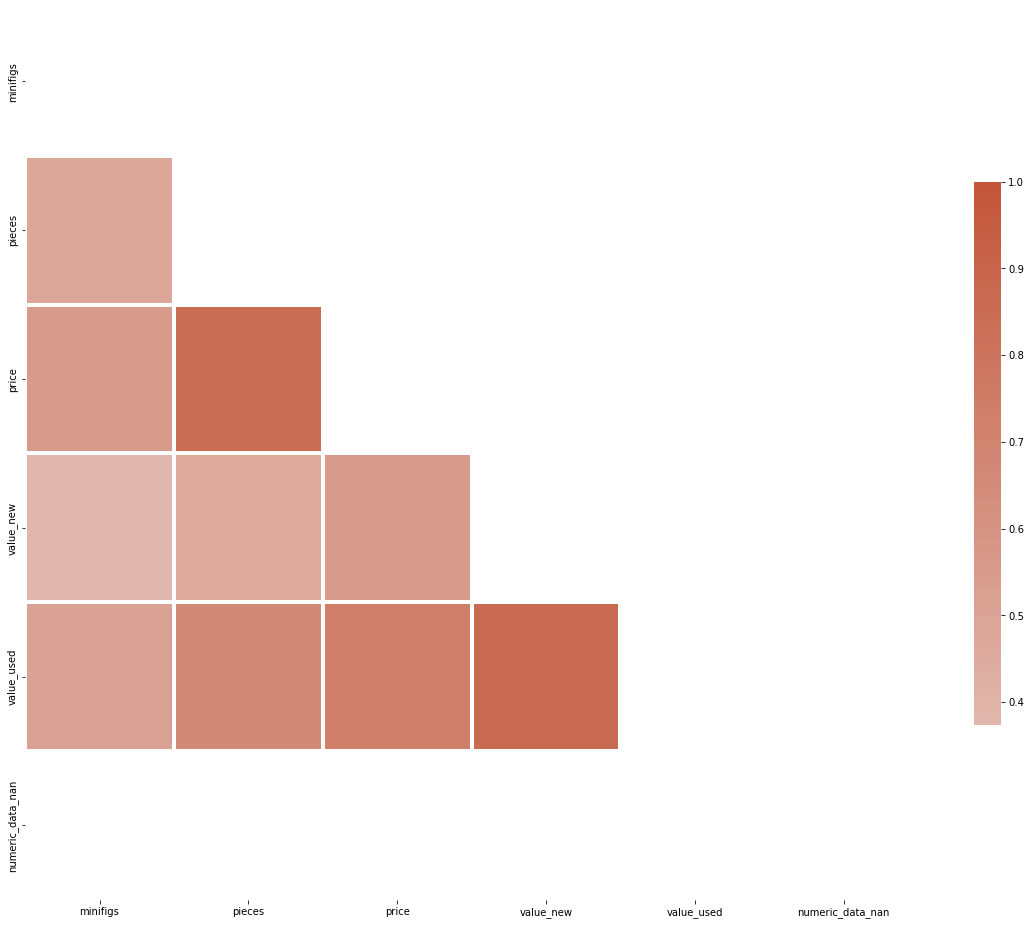

In [1107]:
corr = df.drop(["year","rrp_gbp","rrp_eur"], axis = "columns").corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

f, ax = plt.subplots(figsize = (20,20))

cmap = sns.diverging_palette(200, 20, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, linewidth = 4, cbar_kws = {"shrink":.5})

#### What sets where record breakers in terms of number of minifigures?


In [1108]:
df_minifig_winners = create_record_breaker_dataset(df_sets,"minifigs")
df_minifig_winners.head()

number      theme     subtheme  year                set_name  minifigs  \
0    9361-1      Dacta          NaN  1991                  People     24.00   
1    9293-1      Dacta          NaN  1996       Community Workers     30.00   
2    9247-1  Education          NaN  2005       Community Workers     31.00   
3  852293-1       Gear  Board Games  2008  Castle Giant Chess Set     33.00   

    pieces  price  value_new  value_used launch_date eol_date  \
0    36.00    NaN     150.00         NaN         NaT      NaT   
1   182.00  31.50      83.00       69.00         NaT      NaT   
2   202.00  49.99     138.20       46.34         NaT      NaT   
3 2,292.00 199.99        NaN         NaN         NaT      NaT   

   numeric_data_nan category  cummulative  
0             False      set        24.00  
1             False      set        30.00  
2             False      set        31.00  
3             False      set        33.00

In [1109]:
fig = make_h_bar_chart(df_minifig_winners, "minifigs", df_minifig_winners.index,
                 "theme", "set_name", 
                 "Record breaking sets by no of minifigures")

fig.show()